In [37]:
import os
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean

import datetime as dt
from dateutil.relativedelta import *

import netCDF4
from netCDF4 import Dataset, num2date

import seaborn as sns


In [59]:
# For the bio dataset
base_url = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"

# For the hydro dataset
base_url2 = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"

In [60]:
month_st = 1   # Starting month 
month_ed = 1   # Ending month 
year = 2018    # Year

# Based on the server the file naming convention 
biofiles = [f"{base_url}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]
hydrofiles = [f"{base_url2}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]

Show the area that we are focusing on

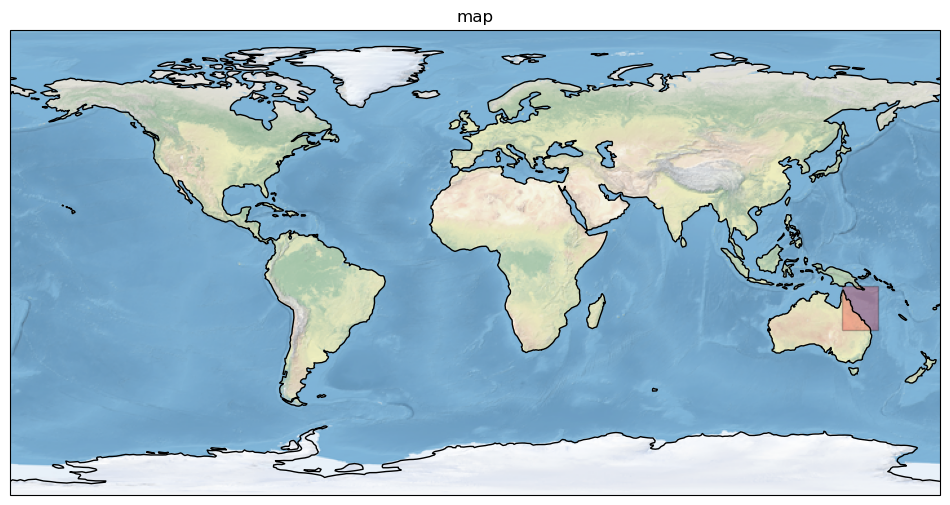

In [47]:
#extent = [np.min(ds.longitude),np.max(ds.longitude),np.min(ds.latitude),np.max(ds.latitude)]
#central_lon = np.mean(extent[:2])
#central_lat = np.mean(extent[2:])

fig0 = plt.figure(figsize=(12,12))
central_lon = 150 #TODO
ax0 = fig0.add_subplot(111,projection=ccrs.PlateCarree())
ax0.stock_img()
ax0.coastlines()
ax0.set_title('map')
ax0.add_patch(mpatches.Rectangle(xy=[142, -26], width=14, height=17, #TODO
                                    facecolor='red',
                                    edgecolor='k',
                                    alpha=0.25,
                                    transform=ccrs.PlateCarree()))
plt.show()


Heron Reefs

In [48]:
# Heron Reefs position
# TODO
reef_lat = -18.82
reef_lon = 147.64
selectedDepthIndex = 16 # corresponding to -0.5 m for GBR4

In [53]:
biofiles_timeseries = []
hydrofiles_timeseries = []

start_date = dt.date(2015, 9, 1)
end_date = dt.date(2021, 2, 1)

current_date = start_date
while current_date <= end_date:
    year = current_date.year
    month = current_date.month
    
    # Construct the filenames for each month and year
    biofiles_timeseries.append(f"{base_url}{year}-{month:02}.nc")
    hydrofiles_timeseries.append(f"{base_url2}{year}-{month:02}.nc")
    
    # Move to the next month
    current_date += relativedelta(months=1)


In [58]:
hydrofiles_timeseries


['http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-2015-09.nc',
 'http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-2015-10.nc',
 'http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-2015-11.nc',
 'http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-2015-12.nc',
 'http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-2016-01.nc',
 'http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereef

In [69]:
biofiles_timeseries[50]

'http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-2019-11.nc'

In [75]:

ds_hydro = xr.open_mfdataset(hydrofiles_timeseries[55:66], chunks={'time': '100MB'})

In [76]:
# Load datasets using xarray
# ds_bio = xr.open_mfdataset(biofiles_timeseries[:44], chunks={'time': '100MB'})
ds_hydro = xr.open_mfdataset(hydrofiles_timeseries, chunks={'time': '100MB'})
# Extract and select nearest values based on latitude and longitude
# alk = ds_bio.alk.sel(longitude=reef_lon, latitude=reef_lat, method='nearest')
# mean_cur = ds_hydro.mean_cur.sel(longitude=reef_lon, latitude=reef_lat, method='nearest')
# wind = ds_hydro.mean_wspeed.sel(longitude=reef_lon, latitude=reef_lat, method='nearest')
temperature = ds_hydro.temp.isel(k=selectedDepthIndex).sel(longitude=reef_lon, latitude=reef_lat, method='nearest')
# salinity = ds_hydro.salt.isel(k=selectedDepthIndex).sel(longitude=reef_lon, latitude=reef_lat, method='nearest')

# TODO check if wanna do rolling
# mean_cur_rolling = mean_cur.rolling(time=120, center=True).mean() # 120 days rolling window
# temperature_rolling = temperature.rolling(time=120, center=True).mean()

# mean_cur_rolling_flat = mean_cur_rolling.values
# temperature_rolling_flat = temperature_rolling.values

# Create pandas dataframe from the extracted data
df = pd.DataFrame({
    'date': pd.to_datetime(temperature.time.values),
    # 'alkalinity': alk.values,
    # 'current': mean_cur.values,
    # 'wind': wind.values,
    'temperature': temperature.values,
    # 'salinity': salinity.values
})

# Save the dataframe to a CSV file
df.to_csv("HeronReefs_timeseries_xarray.csv", sep=" ", index=False)


In [78]:
df.tail()

,date,temperature
2003,2021-02-23 14:00:00,29.562370
2004,2021-02-24 14:00:00,29.095514
2005,2021-02-25 14:00:00,28.860731
2006,2021-02-26 14:00:00,28.784210
2007,2021-02-27 14:00:00,28.563332


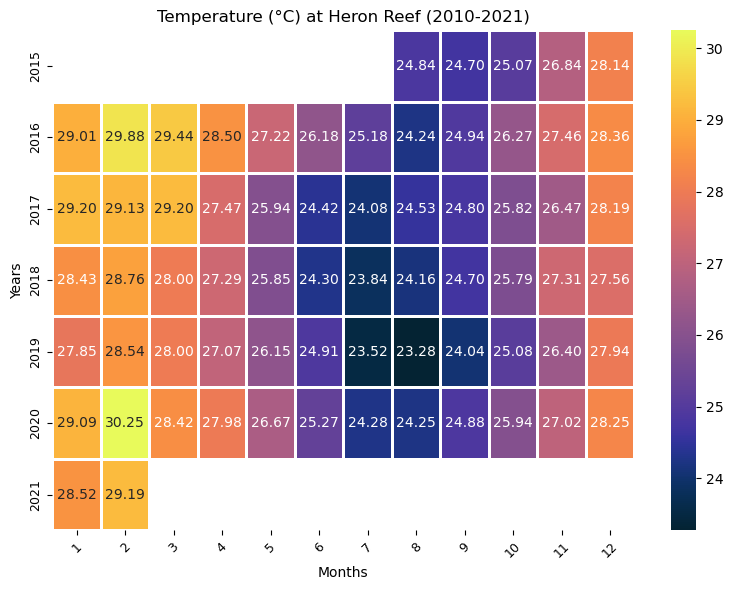

In [79]:
# Add day, month, year columns for heatmap 
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Pivot the data to have months as columns and years as rows for heatmap
# Current_season = df.pivot_table(index="year", columns="month", values="current")
Temp_season = df.pivot_table(index="year", columns="month", values="temperature")

# Plotting Heatmaps

# Current (Speed)
# color = cmocean.cm.speed
# fig, ax = plt.subplots(figsize=(8, 6))
# sns.heatmap(
#     Current_season, annot=True, fmt=".2f", cmap=color, linewidths=1, cbar=True
# )
# ax.set_title("Current Speed (m/s) at Heron Reef (2010-2021)", fontsize=12)
# ax.set_ylabel("Years", fontsize=10)
# ax.set_xlabel("Months", fontsize=10)
# ax.yaxis.set_tick_params(labelsize=9)
# ax.xaxis.set_tick_params(labelsize=9, rotation=45)
# plt.tight_layout()
# plt.show()

# Temperature (Degrees C)
color = cmocean.cm.thermal
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    Temp_season, annot=True, fmt=".2f", cmap=color, linewidths=1, cbar=True
)
ax.set_title("Temperature (°C) at Heron Reef (2010-2021)", fontsize=12)
ax.set_ylabel("Years", fontsize=10)
ax.set_xlabel("Months", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.tight_layout()
plt.show()